# Efficient Grocery Shopping Optimizer (MILP-based)

## Objective

This notebook implements a grocery selection optimizer that:

- Maximizes total preference-weighted protein score
- Meets minimum nutritional requirements
- Respects category-specific variety and monotony constraints
- Operates within a given budget

The approach leverages Mixed Integer Linear Programming (MILP) via the PuLP solver.

## Data Preprocessing

The dataset contains item-level nutritional and price information across stores.  
We ensure correct data types and prepare inputs for optimization.

## Optimization Model

We define the objective and constraints using MILP:

- **Objective**: Maximize total protein score, weighted by subjective preference
- **Constraints**:
  - Budget limit (in dollars)
  - Nutritional bounds (protein, fiber, carbs)
  - Minimum item diversity per category
  - Maximum quantity per item (anti-monotony)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpInteger, PULP_CBC_CMD, LpStatus
from collections import defaultdict

# Load the dataset
df = pd.read_csv("../data/efficient_shopping_optimizer_data.csv")

# Ensure key numeric columns are properly parsed
target_cols = [
    "unit_price", "protein_score", "protein_per_100g",
    "fiber_per_100g", "carbs_per_100g", "quantity_per_purchase", "preference_score"
]
for col in target_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop incomplete rows
df = df.dropna(subset=target_cols + ["category", "item_name", "source"])

# Set budget and nutritional targets
budget = 120
protein_min = 3504
fiber_min, fiber_max = 840, 1800
carbs_min, carbs_max = 3600, 7200

# Initialize MILP model
model = LpProblem("Preference-and-Diversity-Knapsack", LpMaximize)

# Decision variables: purchase quantity (x), item selection flag (y)
x = {i: LpVariable(f"x_{i}", lowBound=0, cat=LpInteger) for i in df.index}
y = {i: LpVariable(f"y_{i}", cat="Binary") for i in df.index}

# Link binary and integer variables
for i in df.index:
    model += x[i] >= y[i]

# Objective: maximize preference-weighted protein score
model += lpSum(x[i] * df.loc[i, "protein_score"] * df.loc[i, "preference_score"] for i in df.index)

# Budget constraint
model += lpSum(x[i] * df.loc[i, "unit_price"] for i in df.index) <= budget

# Nutritional constraints
model += lpSum(x[i] * df.loc[i, "protein_per_100g"] * df.loc[i, "quantity_per_purchase"] for i in df.index) >= protein_min
model += lpSum(x[i] * df.loc[i, "fiber_per_100g"] * df.loc[i, "quantity_per_purchase"] for i in df.index) >= fiber_min
model += lpSum(x[i] * df.loc[i, "fiber_per_100g"] * df.loc[i, "quantity_per_purchase"] for i in df.index) <= fiber_max
model += lpSum(x[i] * df.loc[i, "carbs_per_100g"] * df.loc[i, "quantity_per_purchase"] for i in df.index) >= carbs_min
model += lpSum(x[i] * df.loc[i, "carbs_per_100g"] * df.loc[i, "quantity_per_purchase"] for i in df.index) <= carbs_max

# Diversity constraint: minimum number of unique items per category
min_items_per_category = {
    "protein": 2,
    "vegetables": 1,
    "fruits": 1,
}
category_items = defaultdict(list)
for i in df.index:
    category_items[df.loc[i, "category"]].append(i)
for cat, min_count in min_items_per_category.items():
    if cat in category_items:
        model += lpSum(y[i] for i in category_items[cat]) >= min_count

# Anti-monotony constraint: limit excessive repetition of individual items
repeat_limits = {
    "protein": 4,
    "vegetables": 2,
    "fruits": 4,
}
item_indices_by_name = defaultdict(list)
item_category_map = {}
for i in df.index:
    name = df.loc[i, "item_name"]
    item_indices_by_name[name].append(i)
    item_category_map[name] = df.loc[i, "category"]
for name, indices in item_indices_by_name.items():
    cat = item_category_map[name]
    if cat in repeat_limits:
        model += lpSum(x[i] for i in indices) <= repeat_limits[cat]

# Solve the optimization problem
model.solve(PULP_CBC_CMD(msg=False))
assert LpStatus[model.status] == "Optimal", "❌ Solver failed."

# Organize selected items
total_cost = 0.0
total_score = 0.0
grouped = defaultdict(lambda: defaultdict(list))

for i in df.index:
    qty = int(x[i].varValue)
    if qty > 0:
        store = df.loc[i, "source"]
        category = df.loc[i, "category"]
        grouped[store][category].append((i, qty))

## Results

The optimized shopping list is grouped by store and category:

- Store → Category → Item
- Each item shows:
  - Quantity selected
  - Total cost
  - Total preference-weighted protein score

Below is the full result:

In [5]:
# Display final selection
print("Selected Items (Grouped by Store and Category):")
for store in sorted(grouped.keys()):
    print(f"{store}:")
    for cat in sorted(grouped[store].keys()):
        print(f"  {cat}:")
        for i, qty in sorted(grouped[store][cat], key=lambda x: df.loc[x[0], "item_name"]):
            item = df.loc[i]
            cost = qty * item["unit_price"]
            score = qty * item["protein_score"] * item["preference_score"]
            print(f"    - {item['item_name']} x{qty} | ${cost:.2f} | Score: {score:.2f}")
            total_cost += cost
            total_score += score
    print()

print(f"Total Cost: ${total_cost:.2f}")
print(f"Total Protein Score (weighted): {total_score:.2f}")

Selected Items (Grouped by Store and Category):
Doordash_ALDI:
  protein:
    - Egg x4 | $12.76 | Score: 541.69
    - Tilapia x3 | $26.97 | Score: 270.95

Doordash_Meijer:
  fruit:
    - Nectarine x2 | $1.98 | Score: 26.61
  protein:
    - Chicken Breast x4 | $41.12 | Score: 1000.07
    - Plain Greek Yogurt x4 | $3.00 | Score: 64.33
    - Pork x4 | $17.68 | Score: 358.54
    - Salmon x2 | $15.98 | Score: 136.25
  vegetables:
    - Carrot x2 | $0.44 | Score: 19.78

Total Cost: $119.93
Total Protein Score (weighted): 2418.22


## Visualizations

The following plots summarize the result:

- 🥩 **Protein Contribution per Dollar** (bar chart)
- 🧺 **Category Distribution** (pie chart)

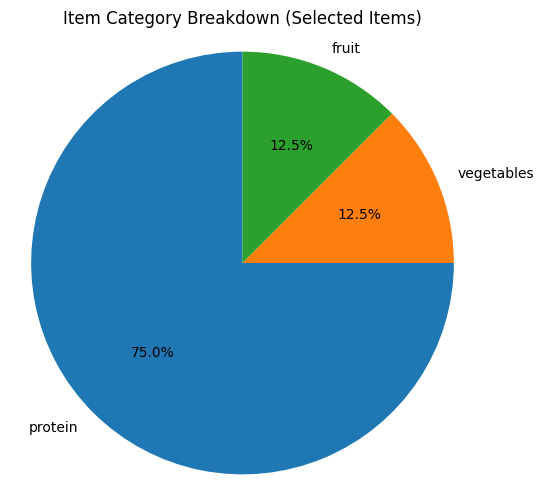

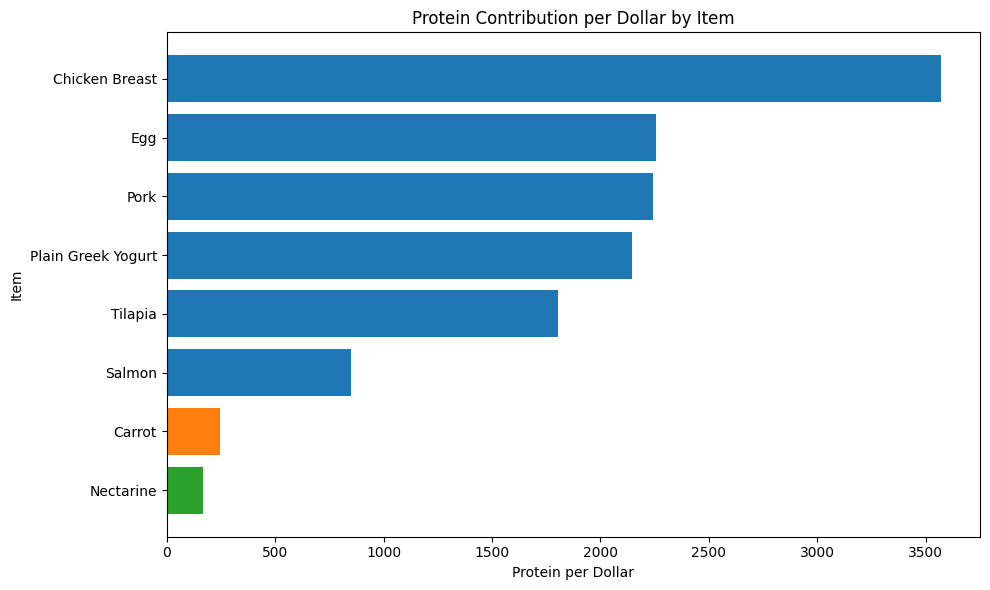

In [11]:
# Create a summary DataFrame from selected items
selected_items = []
for i in df.index:
    qty = int(x[i].varValue)
    if qty > 0:
        row = df.loc[i]
        total_cost = qty * row["unit_price"]
        weighted_score = qty * row["protein_score"] * row["preference_score"]
        selected_items.append({
            "item_name": row["item_name"],

            "category": row["category"],
            "store": row["source"],
            "quantity": qty,
            "unit_price": row["unit_price"],
            "total_cost": total_cost,
            "preference_score": row["preference_score"],
            "protein_score": row["protein_score"],
            "weighted_score": weighted_score,
            "protein_per_dollar": (qty * row["protein_per_100g"] * row["quantity_per_purchase"]) / total_cost if total_cost > 0 else 0
        })

df_selected = pd.DataFrame(selected_items)

# 1. Item Category Breakdown Pie Chart

# Filter only selected items
selected_df = df.copy()
selected_df["quantity_selected"] = [int(x[i].varValue) if x[i].varValue else 0 for i in df.index]
selected_df = selected_df[selected_df["quantity_selected"] > 0]

# Count items per category
category_counts = selected_df["category"].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    category_counts.values,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Item Category Breakdown (Selected Items)")
plt.axis("equal")
plt.show()

# 2. Protein Contribution per Dollar by Item

# Compute total protein and cost per item
selected_df["total_protein"] = (
    selected_df["protein_per_100g"] * selected_df["quantity_per_purchase"] * selected_df["quantity_selected"]
)
selected_df["total_cost"] = selected_df["unit_price"] * selected_df["quantity_selected"]
selected_df["protein_per_dollar"] = selected_df["total_protein"] / selected_df["total_cost"]

# Sort by efficiency
plot_df = selected_df.sort_values("protein_per_dollar", ascending=True)

# Bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(
    plot_df["item_name"],
    plot_df["protein_per_dollar"],
    color=plot_df["category"].map({
        "protein": "#1f77b4",
        "vegetables": "#ff7f0e",
        "fruit": "#2ca02c"
    })
)
plt.xlabel("Protein per Dollar")
plt.ylabel("Item")
plt.title("Protein Contribution per Dollar by Item")
plt.tight_layout()
plt.show()

## Future Work

Possible directions for improvement:

- Allow for user-specific pantry inventory as input
- Introduce dynamic pricing or seasonal availability
- Add constraints on cooking feasibility (e.g., recipes, perishability)
- Include CO₂ impact or sustainability score